In [1]:
import nselib
from nselib import capital_market
import datetime
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.regularizers import l2
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from itertools import cycle 
import plotly.express as px
from numpy import array

In [2]:
today = datetime.date.today().strftime('%d-%m-%Y')
reliance = capital_market.price_volume_and_deliverable_position_data(symbol= 'RELIANCE',  from_date='01-06-2004', to_date=today) 
reliance = reliance.set_index('Date')
reliance.head()

c:\Users\HITESH KOTIAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\nselib\capital_market\capital_market_data.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nse_df = pd.concat([nse_df, data_df], ignore_index=True)


,Symbol,Series,PrevClose,OpenPrice,HighPrice,LowPrice,LastPrice,ClosePrice,AveragePrice,TotalTradedQuantity,TurnoverInRs,No.ofTrades,DeliverableQty,%DlyQttoTradedQty
Date,,,,,,,,,,,,,,
01-Jun-2004,RELIANCE,EQ,429.8,435.0,443.0,432.15,432.55,434.2,438.45,"62,15,267","2,72,50,93,768.45",-,"12,28,368",19.76
02-Jun-2004,RELIANCE,EQ,434.2,435.9,442.95,434.6,442.5,439.45,438.37,"42,96,672","1,88,35,29,783.60",-,"7,93,496",18.47
03-Jun-2004,RELIANCE,EQ,439.45,446.0,452.2,423.1,425.0,428.35,439.86,"72,08,695","3,17,08,31,642.90",-,"11,86,608",16.46
04-Jun-2004,RELIANCE,EQ,428.35,423.0,435.0,422.6,434.8,433.5,429.54,"61,51,647","2,64,23,61,872.30",-,"8,15,123",13.25
07-Jun-2004,RELIANCE,EQ,433.5,435.0,449.6,435.0,449.1,444.8,443.49,"66,11,675","2,93,22,20,358.90",-,"17,50,006",26.47


In [3]:
# I like to see only open high low thus change name and remove Price 
reliance.rename(columns= lambda x : x.replace('Price',''), inplace= True)
reliance.head()

,Symbol,Series,PrevClose,Open,High,Low,Last,Close,Average,TotalTradedQuantity,TurnoverInRs,No.ofTrades,DeliverableQty,%DlyQttoTradedQty
Date,,,,,,,,,,,,,,
01-Jun-2004,RELIANCE,EQ,429.8,435.0,443.0,432.15,432.55,434.2,438.45,"62,15,267","2,72,50,93,768.45",-,"12,28,368",19.76
02-Jun-2004,RELIANCE,EQ,434.2,435.9,442.95,434.6,442.5,439.45,438.37,"42,96,672","1,88,35,29,783.60",-,"7,93,496",18.47
03-Jun-2004,RELIANCE,EQ,439.45,446.0,452.2,423.1,425.0,428.35,439.86,"72,08,695","3,17,08,31,642.90",-,"11,86,608",16.46
04-Jun-2004,RELIANCE,EQ,428.35,423.0,435.0,422.6,434.8,433.5,429.54,"61,51,647","2,64,23,61,872.30",-,"8,15,123",13.25
07-Jun-2004,RELIANCE,EQ,433.5,435.0,449.6,435.0,449.1,444.8,443.49,"66,11,675","2,93,22,20,358.90",-,"17,50,006",26.47


In [4]:
reliance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5083 entries, 01-Jun-2004 to 04-Sep-2024
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Symbol               5083 non-null   object
 1   Series               5083 non-null   object
 2   PrevClose            5083 non-null   object
 3   Open                 5083 non-null   object
 4   High                 5083 non-null   object
 5   Low                  5083 non-null   object
 6   Last                 5083 non-null   object
 7   Close                5083 non-null   object
 8   Average              5083 non-null   object
 9   TotalTradedQuantity  5083 non-null   object
 10  TurnoverInRs         5083 non-null   object
 11  No.ofTrades          5083 non-null   object
 12  DeliverableQty       5083 non-null   object
 13  %DlyQttoTradedQty    5083 non-null   object
dtypes: object(14)
memory usage: 595.7+ KB


In [5]:
# Convert date to date format and Price to numeric

col_to_convert = reliance.columns[2:]
reliance[col_to_convert] = reliance[col_to_convert].replace({'[,,-]': ''}, regex=True).replace(' ', '', regex=True)
reliance[col_to_convert] = reliance[col_to_convert].apply(pd.to_numeric, errors = 'coerce')
reliance.index = pd.to_datetime(reliance.index, errors='coerce')

reliance = reliance.drop(columns =['Average', 'TotalTradedQuantity', 'TurnoverInRs', 'No.ofTrades', 'DeliverableQty', '%DlyQttoTradedQty'])
reliance.columns

Index(['Symbol', 'Series', 'PrevClose', 'Open', 'High', 'Low', 'Last',
       'Close'],
      dtype='object')

Text(0.5, 1.0, 'RELIANCE Stock value changes since 2004')

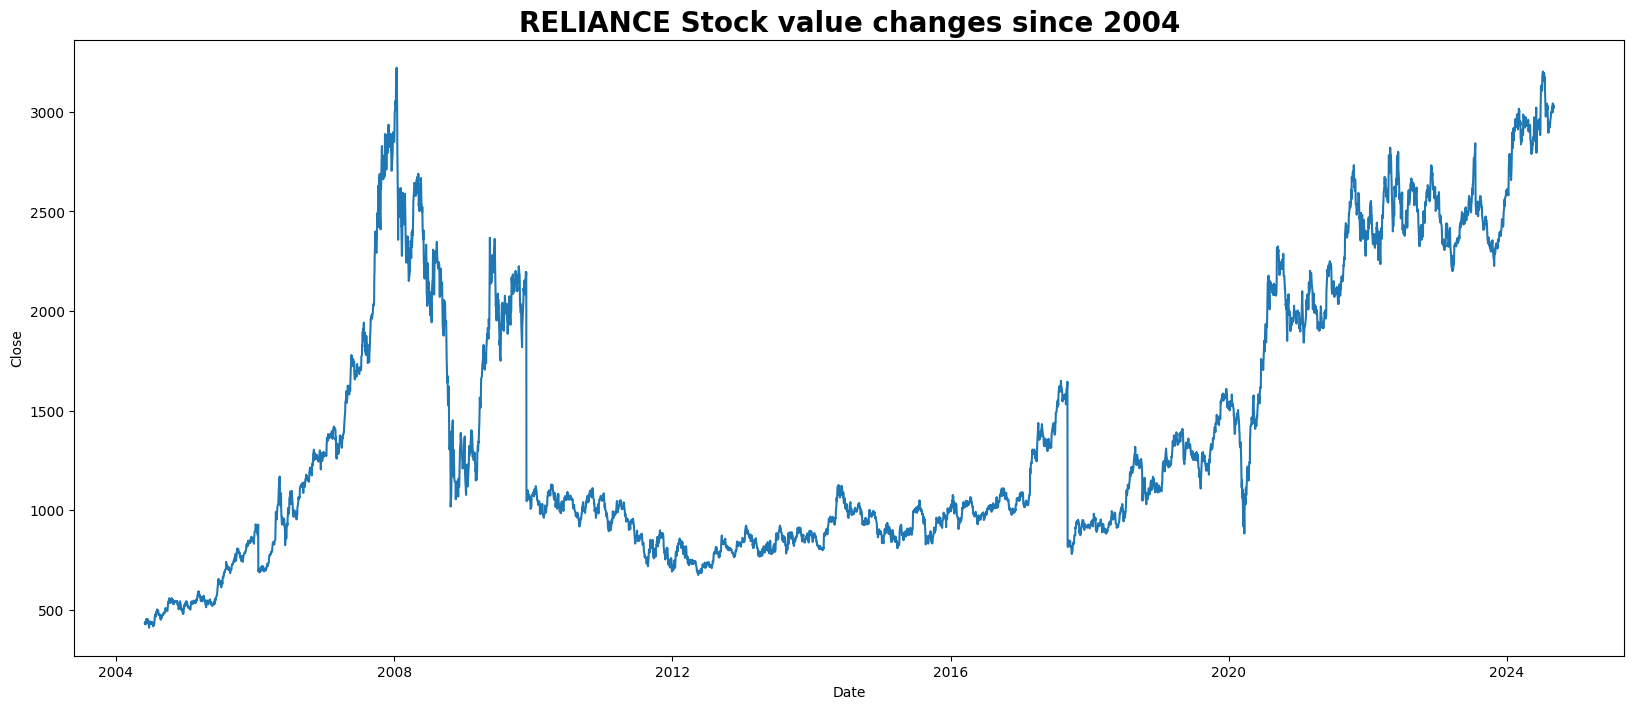

In [6]:
fig=plt.figure(figsize=(20,8))
ax=sn.lineplot(reliance, x = 'Date', y='Close')
plt.xticks(ha = 'center') # ha = horizontakalignment, va = verticalalignment
plt.title("RELIANCE Stock value changes since 2004", size=20, weight='bold')

In [7]:
# We are only intrersted in close price

Close_price = reliance['Close']

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
Close_price = scaler.fit_transform(np.array(Close_price).reshape(-1,1))

In [9]:
# train and test 

train_size = int(len(Close_price)*0.6)

train_data = Close_price[0:train_size, :]
test_data = Close_price[train_size:len(Close_price), :1]

In [10]:
def create_data(data, time_step =1):
    data_X, data_Y = [],[]
    for i in range(len(data)- time_step - 1):
        a = data[i:(i+time_step),0]
        data_X.append(a)
        data_Y.append(data[i+ time_step, 0])
    return np.array(data_X), np.array(data_Y)

In [11]:
X_train, Y_train = create_data(train_data, time_step= 5)
X_test, Y_test = create_data(test_data, time_step= 5)

In [12]:
time_step = 20
X_train, Y_train = create_data(train_data, time_step)
X_test, Y_test = create_data(test_data,time_step)

In [13]:
# Shaping 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [14]:
# Reset the state of global graph or clear the current tf/keras session 
tf.keras.backend.clear_session()

In [15]:
model = Sequential()
model.add(LSTM(50,return_sequences= True, input_shape = (time_step,1), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences= True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer= 'Adam')

c:\Users\HITESH KOTIAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,051 (394.73 KB)

 Trainable params: 101,051 (394.73 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_fit = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=200, batch_size= 32, verbose= 1)

Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.5669 - val_loss: 0.0514
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0297 - val_loss: 0.0118
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms

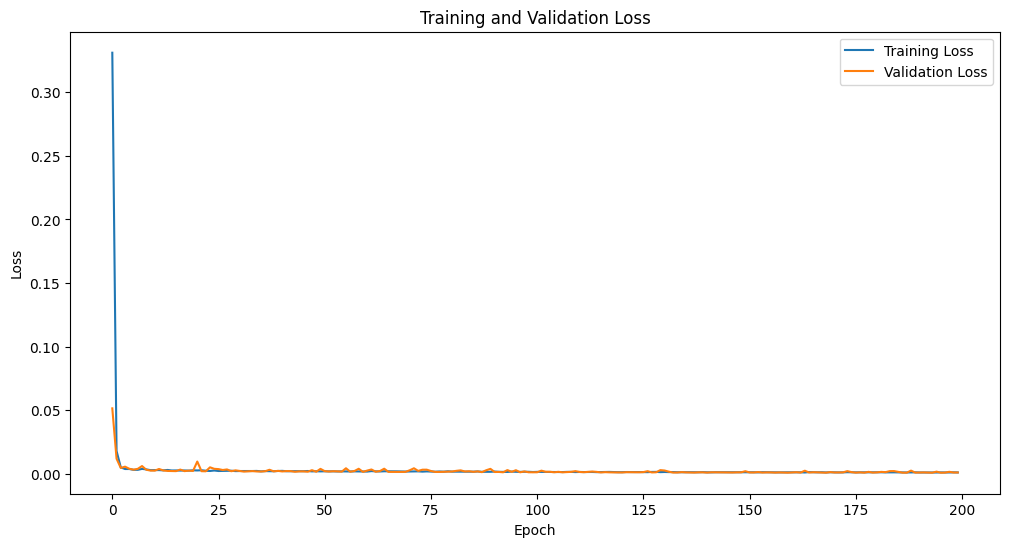

In [18]:
#  TO check if overfit or not using loss and validation loss

history = model_fit.history # Extracting training history

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [20]:
# Important step to transform to the orginal form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)) 
original_Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [21]:
# Evaluating RMSE, MSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_Y_train,train_predict)))
print("Train data MSE: ", mean_squared_error(original_Y_train,train_predict))
print("Test data MAE: ", mean_absolute_error(original_Y_train,train_predict))
print("\n")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_Y_test,test_predict)))
print("Test data MSE: ", mean_squared_error(original_Y_test,test_predict))
print("Test data MAE: ", mean_absolute_error(original_Y_test,test_predict))

Train data RMSE:  64.78914132700173
Train data MSE:  4197.632833890203
Test data MAE:  36.34497755647808


Test data RMSE:  76.30738761946796
Test data MSE:  5822.817405307733
Test data MAE:  53.694011671935144


In [22]:
print("Train data variance regression score:", explained_variance_score(original_Y_train, train_predict))
print("Test data variance regression score:", explained_variance_score(original_Y_test, test_predict))

Train data variance regression score: 0.9857101274345607
Test data variance regression score: 0.9896559690363335


In [23]:
print("Train data R2 score:", r2_score(original_Y_train, train_predict))
print("Test data R2 score:", r2_score(original_Y_test, test_predict))

Train data R2 score: 0.9856074221791715
Test data R2 score: 0.9869894108882624


In [24]:
# Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

print("Train data MGD: ", mean_gamma_deviance(original_Y_train, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_Y_test, test_predict))
print("\n")
print("Train data MPD: ", mean_poisson_deviance(original_Y_train, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_Y_test, test_predict))

Train data MGD:  0.0019928861448072293
Test data MGD:  0.001861450271279474


Train data MPD:  2.640066764250294
Test data MPD:  3.072167470302442


In [25]:
#  Plotting the trained and test data with original data

trainPredictPlot = np.empty_like(Close_price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

testPredictPlot = np.empty_like(Close_price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(Close_price)-1, :] = test_predict

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': reliance.index,
                       'original_close': reliance['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig=plt.figure(figsize=(20,8))
fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock Price','date': 'Date'})


fig.update_layout(title={'text': '<b>Original close price vs Predicted close price<b>','font':dict(size=20),
                         'y': 0.95,'x': 0.5,'xanchor': 'center','yanchor': 'top'},
                  plot_bgcolor='black', font_size=12.5, font_color='black', legend_title_text='Close Price',
                  legend = dict(yanchor="top", y=1, xanchor="left", x=0.4), 
                  font=dict(family="Arial",color="RebeccaPurple"))
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.show()

<Figure size 2000x800 with 0 Axes>

### Now to predict the coming days stock price

In [26]:
new_input=test_data[len(test_data)-time_step:].reshape(1,-1)
list_input=list(new_input)
list_input=list_input[0].tolist()

first_prediction=[]
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(list_input)>time_step):
        
        new_input=np.array(list_input[1:])
        new_input = new_input.reshape((1, time_step, 1))
        
        y_new = model.predict(new_input, verbose=0)
        list_input.extend(y_new[0].tolist())
        list_input=list_input[1:]
       
        first_prediction.extend(y_new.tolist())
        i=i+1
        
    else:
        
        new_input = new_input.reshape((1, time_step,1))
        y_new = model.predict(new_input, verbose=0)
        list_input.extend(y_new[0].tolist())
        
        first_prediction.extend(y_new.tolist())
        i=i+1
               
print("Output of predicted next days: ", first_prediction)

Output of predicted next days:  [[0.8872516751289368], [0.8836957216262817], [0.8738431334495544], [0.8603830337524414], [0.8525684475898743], [0.8512848615646362], [0.8481465578079224], [0.8399420380592346], [0.8318443298339844], [0.8268911838531494]]


last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [31]:
last_days=np.arange(1, time_step+1)
day_pred=np.arange(time_step+1, time_step+pred_days+1)

timestamps = np.concatenate([last_days, day_pred])

temp_mat = np.empty((len(timestamps),1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1)[0].tolist()

last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

last_original_days_value[0:time_step] = scaler.inverse_transform(Close_price[len(Close_price)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step:] = scaler.inverse_transform(np.array(first_prediction).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'timestamp': timestamps,
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig=plt.figure(figsize=(20,8))
fig = px.line(new_pred_plot,x='timestamp', y=['last_original_days_value','next_predicted_days_value'],
              labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title={'text': '<b>Compare last 20 days vs next 10 days<b>','font':dict(size=20),
                         'y': 0.95,'x': 0.35,'xanchor': 'center','yanchor': 'top'},
                  plot_bgcolor='black', font_size=12.5, font_color='black', legend_title_text='Close Price', 
                  font=dict(family="Arial",color="RebeccaPurple"))
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.show()

<Figure size 2000x800 with 0 Axes>

In [45]:
future_dates = pd.date_range(start=reliance.index[-1], periods=len(first_prediction) + 1, freq='B')[1:]
full_dates = reliance.index.tolist() + future_dates.tolist()

full_df=Close_price.tolist()
full_df.extend((np.array(first_prediction).reshape(-1,1)).tolist())
full_df=scaler.inverse_transform(full_df).reshape(1,-1).tolist()[0]

plot_df = pd.DataFrame({'Date': full_dates, 'Close_price': full_df})
plot_df = plot_df.set_index('Date')

names = cycle(['Close price'])

fig = px.line(plot_df, labels={'value': 'Stock price','index': 'Timestamp'})


fig.update_layout(title={'text': '<b>Plotting Reliance closing stock price with prediction<b>','font':dict(size=20),
                         'y': 0.95,'x': 0.5,'xanchor': 'center','yanchor': 'top'},
                  plot_bgcolor='black', font_size=12.5, font_color='black', legend_title_text='Close Price', 
                  legend = {'y': 1,'x': 0.5,'xanchor': 'center','yanchor': 'top'},
                  font=dict(family="Arial",color="RebeccaPurple"))

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.show()